# DOE 本番解析用 (doe-2)

In [1]:
import datetime
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import griddata
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols

### Matplotlib の設定（オプション）

In [2]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 14

### 本日の日付を文字列で取得する関数

In [3]:
def get_date_str()->str:
    dt = datetime.datetime.now()
    date_str = f"{dt.year:4d}-{dt.month:02d}-{dt.day:02d}"
    return date_str

### 交互作用プロット作成関数

In [4]:
def plot_interaction(pairs, target, output):
    n = len(pairs)
    fig, ax = plt.subplots(len(pairs), 1, figsize=(6, n * 4))
    y_min_all = 1e6
    y_max_all = -1e6
    for i, (a, b) in enumerate(pairs):
        sns.pointplot(
            x=a,
            y=target,
            hue=b,
            data=df,
            markersize=6,
            linewidth=1,
            errorbar=None,
            palette="Set2",
            ax=ax[i],
        )
        ax[i].set_title(f"{a} × {b}")
        ax[i].set_xlabel(a)
        ax[i].set_ylabel(target)
        # 凡例のタイトル
        lg = ax[i].legend(fontsize=7)
        lg.set_title(b, prop={"size": 7})

        ax[i].grid()

        # y 軸の最大値・最小値
        y_min, y_max = ax[i].get_ylim()
        if y_min < y_min_all:
            y_min_all = y_min
        if y_max_all < y_max:
            y_max_all = y_max

    # y 軸の範囲を揃える
    for i in range(n):
        ax[i].set_ylim(y_min_all, y_max_all)

    plt.tight_layout()
    plt.savefig(output)
    plt.show()

### 等高線図作成関数

In [5]:
def plot_contour(col_x: str, col_y: str, col_z: str, output: str = ""):
    x = df[col_x]
    y = df[col_y]
    z = df[col_z]

    # グリッド作成
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    Xi, Yi = np.meshgrid(xi, yi)
    # 補間
    Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

    fig, ax = plt.subplots(figsize=(6, 6))

    cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm")
    ax.clabel(cont, inline=True, fontsize=12)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:4,.0f}"))
    ax.set_title(f"{col_x} × {col_y}")
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)

    ax.grid(True, color="gray", linestyle="dotted", linewidth=0.5)
    plt.savefig(output)
    plt.show()

## CSV ファイルの読込

In [6]:
name_doe = "doe-2"
name_code = "7011"
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))
print(list_file)
list_df = list()
for file in list_file:
    path = os.path.join(path_dir, file)
    list_df.append(pd.read_csv(path))
n_tick = len(list_df)
df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
df

['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_20251023.csv', 'ticks_20

,file,code,trade,PERIOD_MA_1,PERIOD_MA_2,THRESHOLD_MR,total
0,ticks_20250819.xlsx,7011,82,60,300,3,53.0
1,ticks_20250819.xlsx,7011,68,90,300,3,87.0
2,ticks_20250819.xlsx,7011,56,120,300,3,130.0
3,ticks_20250819.xlsx,7011,28,60,600,3,116.0
4,ticks_20250819.xlsx,7011,26,90,600,3,108.0
...,...,...,...,...,...,...,...
1804,ticks_20251204.xlsx,7011,4,90,600,7,34.0
1805,ticks_20251204.xlsx,7011,6,120,600,7,26.0
1806,ticks_20251204.xlsx,7011,12,60,900,7,12.0
1807,ticks_20251204.xlsx,7011,8,90,900,7,25.0


## 簡単なサマリ集計

In [7]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "THRESHOLD_MR"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計
summary = df.groupby(factor_cols)[response_cols].mean().reset_index()

#print(df_summary)
#html = df_summary.to_html(index=False)
#print(html)
styled = (
    summary
    .style
    .format({
        "trade": "{:.1f}",
        "total": "{:.2f}"
    })
    .set_table_styles([
        {"selector": "td", "props": "text-align: right;"},
    ])
)

html = styled.to_html()

with open("summary.html", "w", encoding="utf-8") as f:
    f.write(html)

## 【収益】分散分析 (ANOVA)

In [8]:
# オリジナルのデータフレームをコピーして利用
df_anova = df.copy()

# 因子列と応答変数
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "THRESHOLD_MR"]
X = df_anova[factor_cols]
y = df_anova["total"]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=factor_cols)

# 標準化した因子を df に置き換え
for col in factor_cols:
    df_anova[col] = X_scaled_df[col]

# 二次交互作用まで含めるモデル
formula = (
    "total ~ PERIOD_MA_1 + PERIOD_MA_2 + THRESHOLD_MR "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MA_1:THRESHOLD_MR + PERIOD_MA_2:THRESHOLD_MR"
)
model_2way = ols(formula, data=df_anova).fit()

# ANOVAテーブル
anova_table = sm.stats.anova_lm(model_2way, typ=2)
print(f"# of tick files : {n_tick}")
print("=== ANOVA (up to 2-way interactions) ===")
print(anova_table)

# of tick files : 67
=== ANOVA (up to 2-way interactions) ===
                                sum_sq      df         F    PR(>F)
PERIOD_MA_1               5.306799e+02     1.0  0.128969  0.719545
PERIOD_MA_2               2.288932e+04     1.0  5.562707  0.018453
THRESHOLD_MR              5.579466e+03     1.0  1.355957  0.244393
PERIOD_MA_1:PERIOD_MA_2   2.957418e+03     1.0  0.718730  0.396673
PERIOD_MA_1:THRESHOLD_MR  8.692736e+02     1.0  0.211256  0.645840
PERIOD_MA_2:THRESHOLD_MR  4.140908e+02     1.0  0.100635  0.751106
Residual                  7.414834e+06  1802.0       NaN       NaN


## 【収益】主効果＋交互作用 プロット

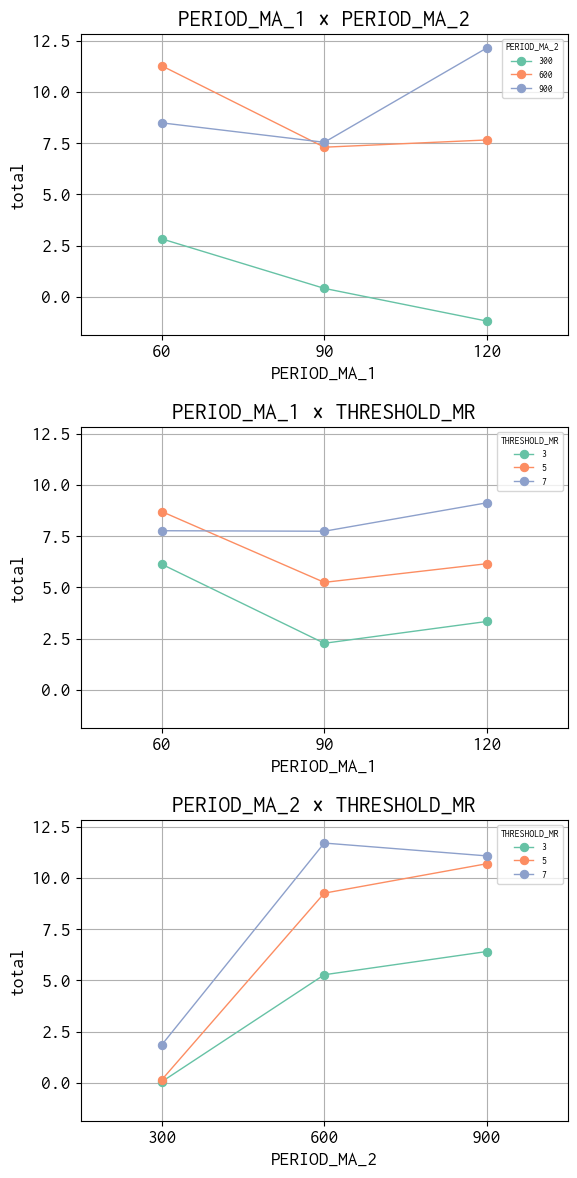

In [10]:
target = "total"
date_str = get_date_str()
output = os.path.join("..", "output", name_doe, f"{name_code}_doe_effects_{target}_{date_str}.png")
#print(output)
pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
    ("PERIOD_MA_1", "THRESHOLD_MR"),
    ("PERIOD_MA_2", "THRESHOLD_MR"),
]
plot_interaction(pairs, target, output)

## 【収益】交互作用の等高線図

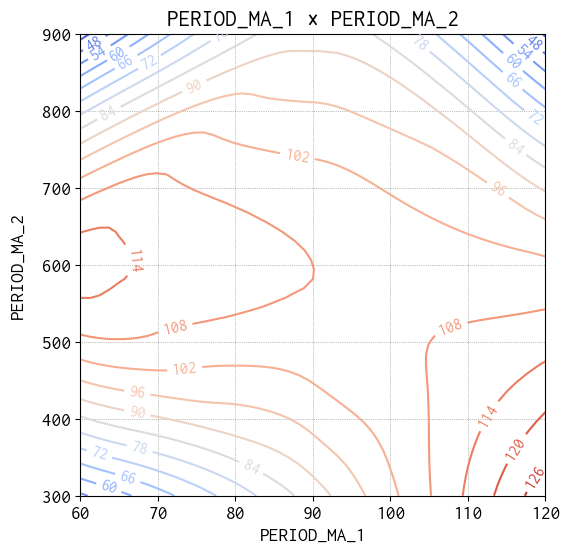

In [11]:
target = "total"
# ===== 1. PERIOD_MA_1 × PERIOD_MA_2 =====
output = ""
output = os.path.join("..", "output", name_doe, f"{name_code}_doe_contour_1_{target}_{date_str}.png")
plot_contour("PERIOD_MA_1", "PERIOD_MA_2", target, output)
# ===== 2. PERIOD_MR × THRESHOLD_MR =====
#output = os.path.join("..", "output", name_doe, f"{name_code}_doe_contour_2_{target}_{date_str}.png")
#plot_contour("PERIOD_MR", "THRESHOLD_MR", target, output)

## 【取引回数】分散分析 (ANOVA)

In [12]:
# オリジナルのデータフレームをコピーして利用
df_anova = df.copy()

# 因子列と応答変数
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "THRESHOLD_MR"]
X = df_anova[factor_cols]
y = df_anova["trade"]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=factor_cols)

# 標準化した因子を df に置き換え
for col in factor_cols:
    df_anova[col] = X_scaled_df[col]

# 二次交互作用まで含めるモデル
formula = (
    "trade ~ PERIOD_MA_1 + PERIOD_MA_2 + THRESHOLD_MR "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MA_1:THRESHOLD_MR + PERIOD_MA_2:THRESHOLD_MR"
)
model_2way = ols(formula, data=df_anova).fit()

# ANOVAテーブル
anova_table = sm.stats.anova_lm(model_2way, typ=2)
print(f"# of tick files : {n_tick}")
print("=== ANOVA (up to 2-way interactions) ===")
print(anova_table)

# of tick files : 67
=== ANOVA (up to 2-way interactions) ===
                                 sum_sq      df            F        PR(>F)
PERIOD_MA_1                36053.761194     1.0   141.751002  1.619594e-31
PERIOD_MA_2               107988.179104     1.0   424.572418  7.032546e-85
THRESHOLD_MR              635308.789386     1.0  2497.815885  0.000000e+00
PERIOD_MA_1:PERIOD_MA_2        5.751244     1.0     0.022612  8.804875e-01
PERIOD_MA_1:THRESHOLD_MR    5196.437811     1.0    20.430608  6.585457e-06
PERIOD_MA_2:THRESHOLD_MR   31971.268657     1.0   125.700044  3.005945e-28
Residual                  458330.994472  1802.0          NaN           NaN


## 【取引回数】主効果＋交互作用 プロット

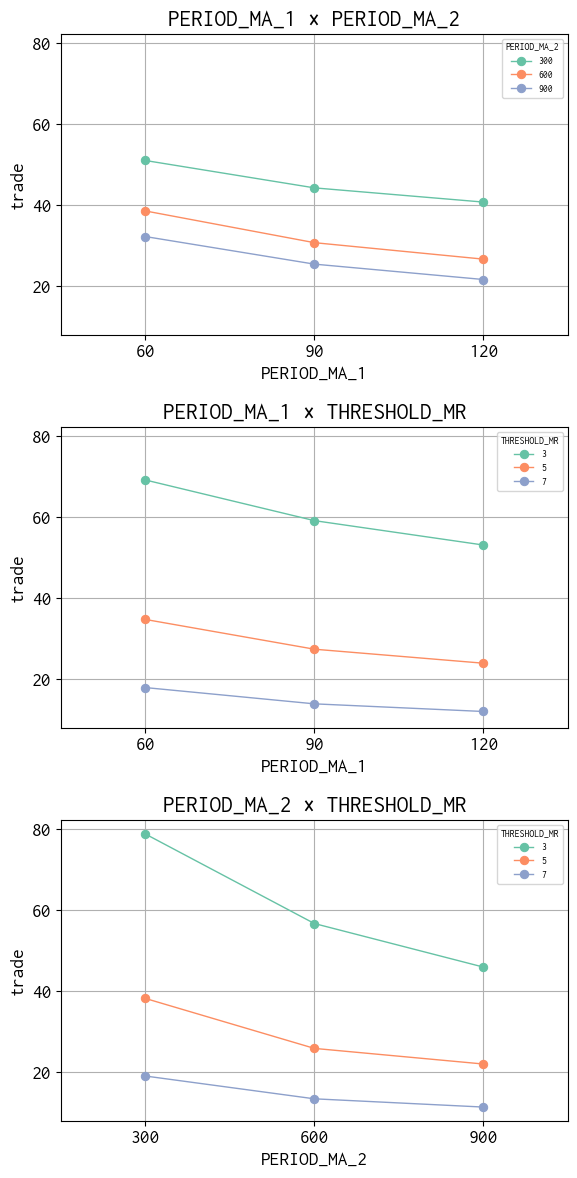

In [13]:
target = "trade"
date_str = get_date_str()
output = os.path.join("..", "output", name_doe, f"{name_code}_doe_effects_{target}_{date_str}.png")
#print(output)
pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
    ("PERIOD_MA_1", "THRESHOLD_MR"),
    ("PERIOD_MA_2", "THRESHOLD_MR"),
]
plot_interaction(pairs, target, output)

## 【取引回数】交互作用の等高線図

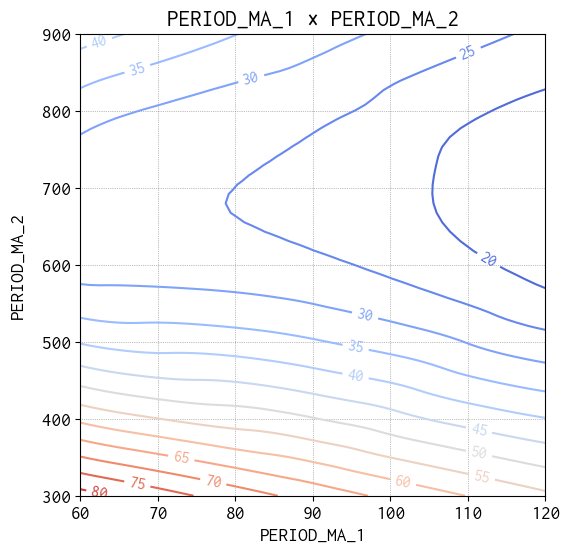

In [14]:
target = "trade"
# ===== 1. PERIOD_MA_1 × PERIOD_MA_2 =====
output = ""
output = os.path.join("..", "output", name_doe, f"{name_code}_doe_contour_1_{target}_{date_str}.png")
plot_contour("PERIOD_MA_1", "PERIOD_MA_2", target, output)
# ===== 2. PERIOD_MR × THRESHOLD_MR =====
#output = os.path.join("..", "output", name_doe, f"{name_code}_doe_contour_2_{target}_{date_str}.png")
#plot_contour("PERIOD_MR", "THRESHOLD_MR", target, output)